In [1]:
import matplotlib
matplotlib.use("Agg")

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
%matplotlib inline
mpl_cols = ['#3388dd', '#aa3377', '#449911']

In [4]:
import os, sys, inspect
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(
        os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],
                     '..', '..', 'labeled-experiments', 'nn-classifiers')))
cmd_folder2 = os.path.realpath(os.path.abspath(
        os.path.join(os.path.split(inspect.getfile( inspect.currentframe() ))[0],
                     '..')))

if cmd_folder not in sys.path:
    print 'Added {0} to path.'.format(cmd_folder)
    sys.path.insert(0, cmd_folder)

if cmd_folder2 not in sys.path:
    print 'Added {0} to path.'.format(cmd_folder2)
    sys.path.insert(0, cmd_folder2)

Added /Users/an/dev-repos/factory-robot-simulator/labeled-experiments/nn-classifiers to path.
Added /Users/an/dev-repos/factory-robot-simulator/seq-prediction to path.


In [5]:
import labeling_network as lbln

from matplotlib import pyplot as plt
import theano
import theano.tensor as T
import numpy as np
from labeling_network import FullyConnectedLayer, ConvPoolLayer

import time
import datetime

Running with a CPU.  If this is not desired, then the modify network3.py to set
the GPU flag to True.


In [6]:
rng = np.random.RandomState(12345678)

In [7]:
dataPath = '../../../factory-robot-data/imgs_2015-10-26/'

In [8]:
import dataloader

#### Load image data. 

In [9]:
n_direction_sensors = 9
n_classes = 2
load_time_start = time.time()
# all_data, v__, t__ = lbln.load_data_shared(
#                      dataPath,
#                      'capture',
#                      dataPath + 'labels.dat',
#                      n_train=30000,
#                      n_validation=0,
#                      n_test=0,
#                      label_mask=-1,
#                      n_direction_sensors=n_direction_sensors,
#                      n_classes=n_classes,
#                      shuffle_rng=rng,
#                      hsv='hsv')

# def load_images(lower, upper, file_path, file_prefix, hsv=None):
#     return np.asarray([load_training_img(i, file_path, file_prefix, hsv)
#                        for i in range(lower, upper)])


# reverse target and label
all_images = lbln.load_images(0, 30000, dataPath, 'capture', hsv='hsv')

print 'Loading data took {0:.5} seconds'.format(time.time() - load_time_start)

Loading data took 44.794 seconds


#### Load sequence data.

In [10]:
sequence_length = 500
crop_end = 2
n_train = 0
n_test = 60
n_data = sequence_length * (n_train + n_test)
input_length = 21
percept_length = 18

print 'load data ({0})...'.format(n_data)
data = dataloader.get_data(0, n_data + 1, 
                           data_path_lab=dataPath+'labels.dat', 
                           data_path_act=dataPath+'actions.dat')
inputs, percepts, cam_imgs = dataloader.make_batches(data, sequence_length, crop_end=crop_end, input_images=all_images)
x_train = inputs[:n_train]
y_train = percepts[:n_train]
imgs_train = cam_imgs[:n_train]

x_test = inputs[n_train:]
y_test = percepts[n_train:]
imgs_test = cam_imgs[n_train:]

load data (30000)...


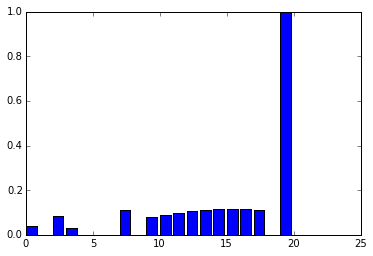

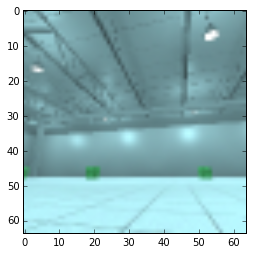

In [11]:
plt.bar(np.arange(21), x_test[1, 50])
plt.show()
plt.imshow(matplotlib.colors.hsv_to_rgb(imgs_test[1, 50].reshape(64, 64, 3)))
plt.show()

In [12]:
# n_train = 150000
# n_valid = 5000
# n_test = 1000

# n_direction_sensors=9
# n_classes=2
# n_actions=3
# delta_t = 2
# n_past = 15
# n_future = 12


# lower = 0
# upper = n_train + n_valid + n_test + delta_t*n_past



# load_time_start = time.time()
# label_data_raw = lbln.load_labeling_data(dataPath+'labels.dat', lower, upper, mask=-1, 
#                                          n_direction_sensors=n_direction_sensors, 
#                                          n_classes=n_classes)
# actions_raw = convert_actions(load_action_data(dataPath+'actions.dat', lower, upper), 
#                               n_actions=n_actions)

# all_data = construct_training_examples(label_data_raw, actions_raw, delta_t, n_past, n_future)
# all_data = shuffle_data(all_data, rng)

# training_xs = theano.shared(all_data[0][:n_train], borrow=True)
# training_ts = theano.shared(all_data[1][:n_train], borrow=True)

# valid_xs = theano.shared(all_data[0][n_train: n_train+n_valid], borrow=True)
# valid_ts = theano.shared(all_data[1][n_train: n_train+n_valid], borrow=True)

# test_xs = theano.shared(all_data[0][n_train+n_valid:], borrow=True)
# test_ts = theano.shared(all_data[1][n_train+n_valid:], borrow=True)


# print 'Loading data took {0:.5} seconds'.format(time.time() - load_time_start)

In [13]:
def visualize_frame(ax, percept, n_sensors, action, color=mpl_cols[0]):
    percept_length = len(percept)
    n_actions = len(action)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.bar(np.arange(percept_length), percept, 
           color=color,
           edgecolor='none',
           align='center')
    ax.bar(np.arange(percept_length, percept_length + n_actions), action,
          color=mpl_cols[1],
          edgecolor='none',
          align='center')
    ax.set_xlim(-0.5, percept_length+n_actions-0.5)
    ax.set_ylim(0, 1)
    ax.axvline(x=n_sensors-0.5)
    ax.axvline(x=percept_length-0.5)

def visualize_example(x, t, percept_length, n_sensors, n_actions, n_past, n_future):
    fig = plt.figure(figsize=(6, 1*(n_past+1)))
    for i in xrange(n_past):
        ax = fig.add_subplot(n_past + n_future, 1, i + 1)
        visualize_frame(ax, 
                        x[i*(percept_length + n_actions):
                             (i + 1)*percept_length + i*n_actions],
                        n_sensors,
                        x[(i+1)*percept_length + i*n_actions:
                          (i + 1)*(percept_length + n_actions)])
    for i in xrange(n_future-1):
        print x[n_past*(percept_length + n_actions) + i*n_actions:
                n_past*(percept_length + n_actions) + (i + 1)*n_actions]      
    
    for i in xrange(n_future):
        ax = fig.add_subplot(n_past + n_future, 1, n_past + i + 1)
        visualize_frame(ax, 
                        t[i*percept_length: (i+1)*percept_length], 
                        n_sensors, 
                        np.zeros(n_actions), 
                        color=mpl_cols[2])
    plt.show()

## Visualize predictions

#### Load networks

In [14]:
from keras.models import model_from_json
def load_model(architecture_filename, weights_filename):
    model = model_from_json(open(architecture_filename).read())
    model.load_weights(weights_filename)
    return model

In [15]:
import time
from keras.models import model_from_json
print 'Loading and compiling model. This may take a while.'
dir_name = 'trained-networks/'
file_prefix = 'dec20151026094429'
visualization_architecture_filename = dir_name + file_prefix + '.json'
visualization_weights_filename = dir_name + file_prefix + '.h5'

prediction_architecture_filename = '../20151025out_100/json.dat'
prediction_weights_filename = '../20151025out_100/model_checkpoint.h5'
time.sleep(0.1)


tic = time.time()
prediction_model = load_model(prediction_architecture_filename, prediction_weights_filename)
visualization_model = load_model(visualization_architecture_filename, visualization_weights_filename)
toc = time.time()
print 'loading the models took {0} seconds'.format(toc - tic)

Loading and compiling model. This may take a while.
loading the models took 107.407371998 seconds


/usr/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:135: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


#### Predictions.

In [16]:
def recursive_prediction(model, past, next_actions):
    past_percepts = np.array(past)
    n_predict = next_actions.shape[0]
    
    predictions = []
    for i in xrange(n_predict):
        complete_prediction = model.predict(past_percepts)
        current_prediction = complete_prediction[0, -1]
        predictions.append(current_prediction)
        current_action = next_actions[i]
        next_input = np.append(current_prediction, current_action)
        past_percepts[:-1] = past_percepts[1:]
        past_percepts[-1] = next_input
        
    return np.array(predictions)

In [17]:
# print recursive_prediction(model=prediction_model, 
#                            past=x_test[0:1, 0:250], 
#                            next_actions=x_test[0, 100:125, -3:])

In [21]:
# xs = valid_xs.get_value()
# ts = valid_ts.get_value()

# def extract_frames_from_x(x, n_direction_sensors, n_classes, n_actions, n_past):
#     return np.asarray([x[ i   *(n_direction_sensors*n_classes + n_actions):
#                          (i+1)*n_direction_sensors*n_classes + i*n_actions] for i in xrange(n_past)])
# def extract_frames_from_t(t, n_direction_sensors, n_classes, n_future):
#     return np.asarray([t[i*n_direction_sensors*n_classes:
#                          (i+1)*n_direction_sensors*n_classes] for i in xrange(n_future)])

# # print extract_frames_from_x(xs[0], n_direction_sensors, n_classes, n_actions, n_past)
# # print extract_frames_from_t(ts[0], n_direction_sensors, n_classes, n_past)


def make_animation(filename, frames_past, frames_target, frames_predicted, visualization_net, n_direction_sensors,
                  past_real_images=None, target_real_images=None):
    import matplotlib.animation as manimation

    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title='anim', artist='an', comment='comment')
    writer = FFMpegWriter(fps=8, metadata=metadata)

    fig = plt.figure(figsize=(8, 16))
    
    def export_frame(fig, writer, frame_left, frame_right, n_direction_sensors, actual_img=None):
        fig.clear()
        
        if actual_img is None:
            vis_l = (visualization_net.predict(np.asarray([frame_left]))).reshape(64, 64, 3)
        else:
            vis_l = actual_img.reshape(64, 64, 3)
        
        vis_l = matplotlib.colors.hsv_to_rgb(vis_l)
        
        vis_r = (visualization_net.predict(np.asarray([frame_right]))).reshape(64, 64, 3)
        vis_r = matplotlib.colors.hsv_to_rgb(vis_r)

        ax1 = fig.add_subplot(3, 1, 2)
#         ax1.imshow(vis_l, interpolation='nearest')



        ax2 = fig.add_subplot(3, 1, 1)
#         ax2.imshow(vis_r, interpolation='nearest')

        ax3 = fig.add_subplot(3, 1, 3)
        ax3.set_ylim(0, 1)
#         for j in xrange(len(frame_left) / n_direction_sensors):
#             ax3.bar(np.arange(n_direction_sensors) + j*n_direction_sensors,
#                     frame_left[j*n_direction_sensors:(j+1)*n_direction_sensors],
#                     color=mpl_cols[j % len(mpl_cols)],
#                     edgecolor='none')
            
#         ax3.bar(np.arange(frame_left.shape[0])-0.5, frame_left, color='#99ccee', linewidth=0, align='center')
#         ax3.bar(np.arange(frame_left.shape[0])-0.5,
#                frame_left - frame_right, 
#                bottom = frame_right,
#                width=0.35, 
#                color='#660000', 
#                alpha=1.0,
#                linewidth=0, 
#                align='center')



#         ax1.set_frame_on(False)
#         ax1.get_yaxis().set_visible(False)
#         ax1.get_xaxis().set_visible(False)
#         ax2.set_frame_on(False)
#         ax2.get_yaxis().set_visible(False)
#         ax2.get_xaxis().set_visible(False)            
#         ax3.get_xaxis().set_visible(False)
        writer.grab_frame()
    
    with writer.saving(fig, filename, 300):
        for i in xrange(len(frames_past)):
            if past_real_images is None:
                export_frame(fig, writer, frames_past[i], frames_past[i], n_direction_sensors)
            else:
                export_frame(fig, writer, frames_past[i], frames_past[i], n_direction_sensors, 
                             past_real_images[i])
        for i in xrange(len(frames_target)):
            if target_real_images is None:
                export_frame(fig, writer, frames_target[i], frames_predicted[i], n_direction_sensors)
            else:
                export_frame(fig, writer, frames_target[i], frames_predicted[i], n_direction_sensors,
                            target_real_images[i])
            

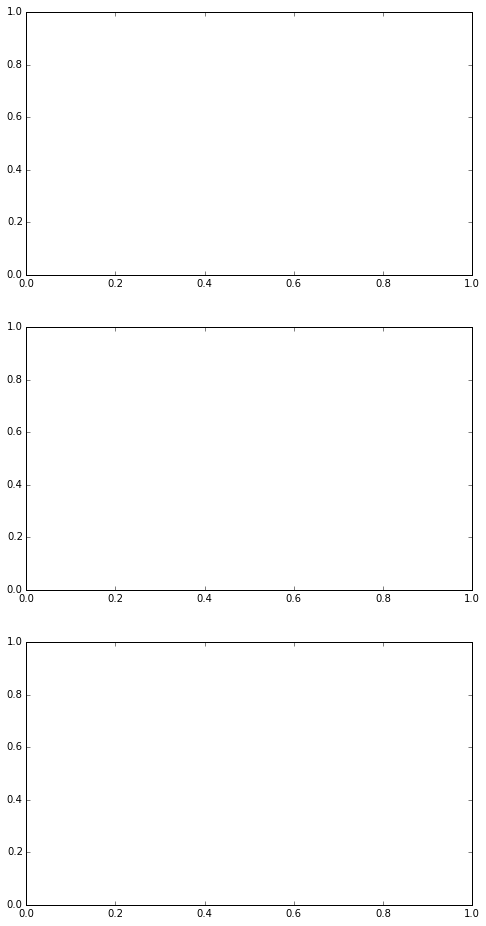

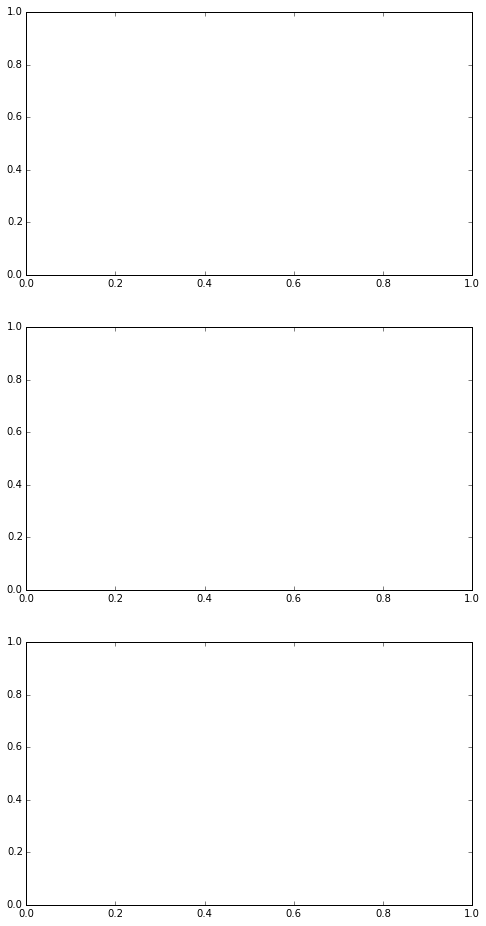

In [22]:
# batch_index = 20

for batch_index in xrange(2):
    n_seq_init = 25
    n_predict = 25

    past_frames = x_test[batch_index, 0:n_seq_init]
    past_real_images = imgs_test[batch_index, 0:n_seq_init]
    next_actions = x_test[batch_index, n_seq_init: n_seq_init+n_predict, -3:]

    predicted_frames = recursive_prediction(prediction_model,
                                            np.asarray([past_frames]),
                                            next_actions)

    target_frames = x_test[batch_index, n_seq_init: n_seq_init+n_predict, :-3]
    target_real_images = imgs_test[batch_index, n_seq_init: n_seq_init+n_predict]

    make_animation('anims-2015-10-26/anim{0}.mp4'.format(batch_index), 
                   past_frames[:, :-3], 
                   target_frames,
                   predicted_frames,  
                   visualization_model,
                   n_direction_sensors,
                   past_real_images=past_real_images,
                   target_real_images=target_real_images)

